<a href="https://colab.research.google.com/github/vgnesh/BigMartSales/blob/main/BigMartSalesComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   chk if year is required or age diff is enuf
*   chk if item identifier is good as index or seperate column
*   chk ordinal for location type and outlet type
*   chk to remove outliers w.r.t item identifier value counts < some value

#To-Do

* drop item identifier cause having uncommon items

# Questions
* why is visibility 0 in some cases

# Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel

In [2]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

In [3]:
train_original = pd.read_csv('BigMartTrain.csv')
test_original = pd.read_csv('BigMartTest.csv')

In [4]:
train = train_original.copy()
test = test_original.copy()

# EDA

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
train.loc[train.Item_Identifier == 'FDN15']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
2,FDN15,17.5,Low Fat,0.016760,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270
759,FDN15,17.5,Low Fat,0.028009,Meat,141.718,OUT010,1998,NaN,Tier 3,Grocery Store,419.454
4817,FDN15,17.5,Low Fat,0.016720,Meat,139.918,OUT013,1987,High,Tier 3,Supermarket Type1,419.454
5074,FDN15,17.5,Low Fat,0.016802,Meat,138.518,OUT018,2009,Medium,Tier 3,Supermarket Type2,2376.906
6163,FDN15,17.5,Low Fat,0.016768,Meat,141.418,OUT045,2002,NaN,Tier 2,Supermarket Type1,1957.452
6952,FDN15,NaN,Low Fat,0.029299,Meat,140.318,OUT019,1985,Small,Tier 1,Grocery Store,139.818
8349,FDN15,NaN,Low Fat,0.016653,Meat,139.518,OUT027,1985,Medium,Tier 3,Supermarket Type3,2936.178


In [ ]:
test.Outlet_Establishment_Year.describe()

count    5681.000000
mean     1997.828903
std         8.372256
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64

In [ ]:
train.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [ ]:
352/(528+352)

0.4

In [ ]:
test.Outlet_Identifier.value_counts()

OUT027    624
OUT013    621
OUT049    620
OUT046    620
OUT035    620
OUT045    619
OUT018    618
OUT017    617
OUT010    370
OUT019    352
Name: Outlet_Identifier, dtype: int64

In [ ]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales'], dtype='object')

In [ ]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
train.Outlet_Type.value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
train.Outlet_Type.value_counts()

1    5577
0    1083
3     935
2     928
Name: Outlet_Type, dtype: int64

In [ ]:
train_unique_item_identifier = train.Item_Identifier.unique().sort()
test_unique_item_identifier = test.Item_Identifier.unique().sort()

In [ ]:
np.array_equal(train_unique_item_identifier, test_unique_item_identifier)

True

In [ ]:
np.sort(train.Item_Identifier.unique())

array([   0,    1,    2, ..., 1556, 1557, 1558])

In [ ]:
np.sort(test.Item_Identifier.unique())

array([   0,    1,    2, ..., 1540, 1541, 1542])

In [ ]:
train_original.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


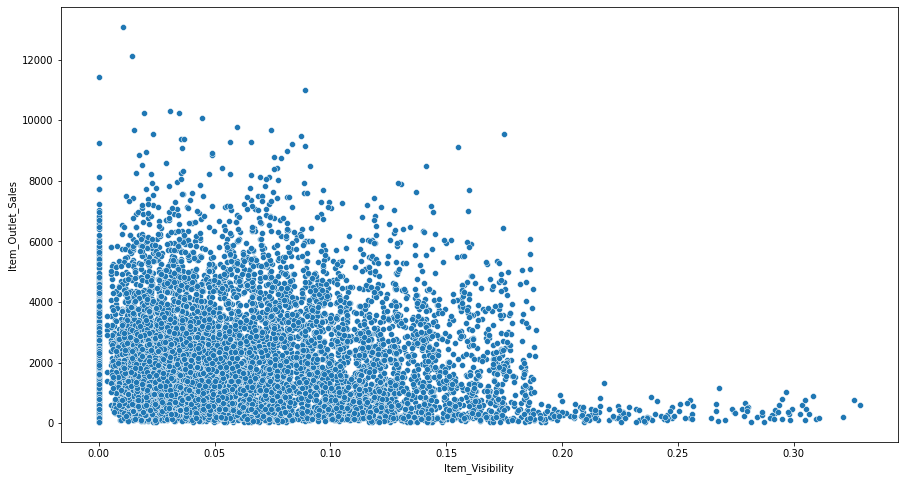

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=train_original.Item_Visibility, y=train_original.Item_Outlet_Sales)

In [ ]:
order = train_original.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].mean().sort_values(ascending=True).index
map1=dict([i for i in zip(order,range(1,len(order)+1))])
train_original['Outlet_Identifier'].apply(lambda x : map1[x])

In [ ]:
print(dict([i for i in zip(order,range(1,len(order)+1))]))

{'OUT010': 1, 'OUT019': 2, 'OUT018': 3, 'OUT045': 4, 'OUT046': 5, 'OUT013': 6, 'OUT017': 7, 'OUT049': 8, 'OUT035': 9, 'OUT027': 10}


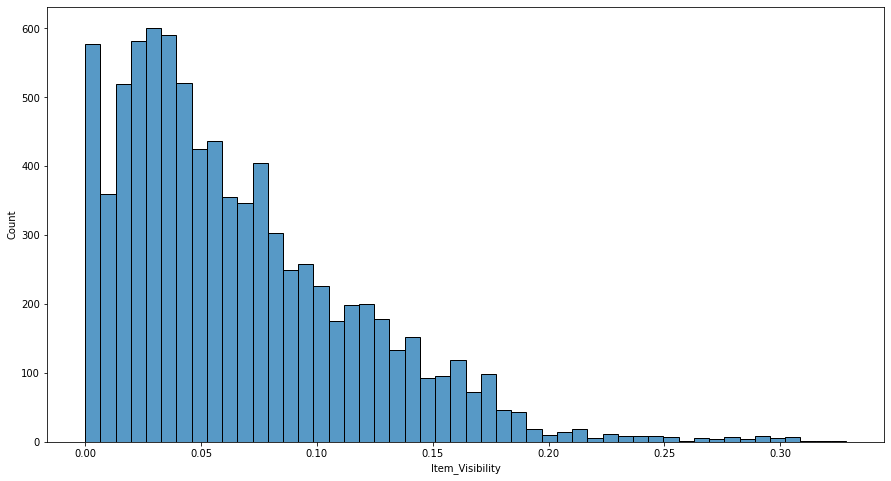

In [ ]:
   plt.figure(figsize=(15,8))
sns.histplot(data= train_original, x=train_original.Item_Visibility)

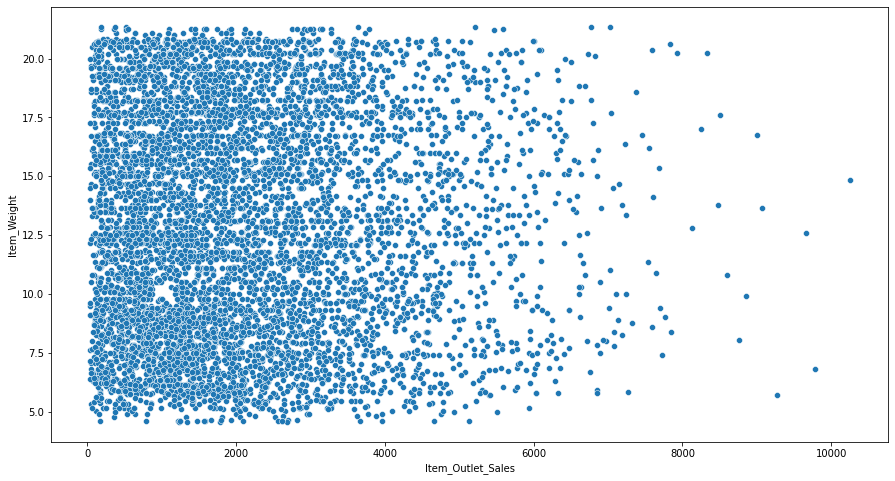

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(y=train_original.Item_Weight,x=train_original.Item_Outlet_Sales)

In [ ]:
null_outlet_size = train_original.loc[train_original.Outlet_Size.isnull()]

In [ ]:
null_outlet_size.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales'], dtype='object')

In [ ]:
train_original.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [ ]:
null_outlet_size.Outlet_Identifier.value_counts()

OUT045    929
OUT017    926
OUT010    555
Name: Outlet_Identifier, dtype: int64

In [ ]:
test_original.loc[test_original.Outlet_Size.isnull()].Outlet_Identifier.value_counts()

OUT045    619
OUT017    617
OUT010    370
Name: Outlet_Identifier, dtype: int64

In [ ]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [ ]:
train.shape

(8523, 12)

# Preprocessing

In [ ]:
encoder = LabelEncoder()

In [ ]:
train.Item_Identifier = encoder.fit_transform(train.Item_Identifier)
test.Item_Identifier = encoder.fit_transform(test.Item_Identifier)

In [ ]:
Item_Fat_Content = train.Item_Fat_Content.map({'LF':'Low Fat','reg': 'Regular', 'low fat':'Low Fat', 'Low Fat':'Low Fat', 'Regular':'Regular'})
train.Item_Fat_Content = encoder.fit_transform(Item_Fat_Content)
del Item_Fat_Content

Item_Fat_Content = test.Item_Fat_Content.map({'LF':'Low Fat','reg': 'Regular', 'low fat':'Low Fat', 'Low Fat':'Low Fat', 'Regular':'Regular'})
test.Item_Fat_Content = encoder.fit_transform(Item_Fat_Content)
del Item_Fat_Content

In [ ]:
train.Item_Type = encoder.fit_transform(train.Item_Type)
test.Item_Type = encoder.fit_transform(test.Item_Type)

In [ ]:
train.Outlet_Identifier = train.Outlet_Identifier.str.lstrip('OUT').astype(np.int8)
test.Outlet_Identifier = test.Outlet_Identifier.str.lstrip('OUT').astype(np.int8)

In [ ]:
train['Outlet_Age'] = 2013 - train.Outlet_Establishment_Year
test['Outlet_Age'] = 2013 - test.Outlet_Establishment_Year

In [ ]:
train.Outlet_Location_Type = encoder.fit_transform(train.Outlet_Location_Type)
test.Outlet_Location_Type = encoder.fit_transform(test.Outlet_Location_Type)

In [ ]:
train.Outlet_Type = encoder.fit_transform(train.Outlet_Type)
test.Outlet_Type = encoder.fit_transform(test.Outlet_Type)

In [ ]:
train.Outlet_Size.fillna(value='Unknown', inplace = True)
test.Outlet_Size.fillna(value='Medium', inplace = True)

In [ ]:
enc=OrdinalEncoder(categories=[['Small', 'Medium', 'High']], dtype=np.int8)
train.Outlet_Size = enc.fit_transform(train.Outlet_Size.values.reshape(-1, 1))
test.Outlet_Size = enc.fit_transform(test.Outlet_Size.values.reshape(-1, 1))

In [ ]:
zeros_train = np.zeros((train.shape[0],1), dtype=np.int8)
zeros_train[train.Item_Visibility == 0] = 1
train['zero_visibility'] = zeros_train

zeros_test = np.zeros((test.shape[0],1), dtype=np.int8)
zeros_test[test.Item_Visibility == 0] = 1
test['zero_visibility'] = zeros_test

# Missing values

In [ ]:
train.Item_Weight = train.Item_Weight.fillna(train.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'))
test.Item_Weight = test.Item_Weight.fillna(test.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'))

# Transformed dataset

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,zero_visibility
0,156,9.30,0,0.016047,4,249.8092,49,1999,1,0,1,3735.1380,14,0
1,8,5.92,1,0.019278,14,48.2692,18,2009,1,2,2,443.4228,4,0
2,662,17.50,0,0.016760,10,141.6180,49,1999,1,0,1,2097.2700,14,0
3,1121,19.20,1,0.000000,6,182.0950,10,1998,1,2,0,732.3800,15,1
4,1297,8.93,0,0.000000,9,53.8614,13,1987,2,2,1,994.7052,26,1


In [ ]:
train.drop(labels=['Outlet_Establishment_Year'], axis=1, inplace=True)
test.drop(labels=['Outlet_Establishment_Year'], axis=1, inplace=True)

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,zero_visibility
0,156,9.30,0,0.016047,4,249.8092,49,1,0,1,3735.1380,14,0
1,8,5.92,1,0.019278,14,48.2692,18,1,2,2,443.4228,4,0
2,662,17.50,0,0.016760,10,141.6180,49,1,0,1,2097.2700,14,0
3,1121,19.20,1,0.000000,6,182.0950,10,1,2,0,732.3800,15,1
4,1297,8.93,0,0.000000,9,53.8614,13,2,2,1,994.7052,26,1


In [ ]:
y = train.Item_Outlet_Sales
X = train.drop(labels=['Item_Outlet_Sales'], axis=1) 

# Model building

### Train - validation spilt

Lets try to find by what parameter was spliting based on in this competition. After some research on the dataset, found that the split was done based on 'Outlet_Identifier' column.

In [ ]:
train.Outlet_Identifier.value_counts()

27    935
13    932
46    930
35    930
49    930
45    929
18    928
17    926
10    555
19    528
Name: Outlet_Identifier, dtype: int64

In [ ]:
test.Outlet_Identifier.value_counts()

27    624
13    621
35    620
46    620
49    620
45    619
18    618
17    617
10    370
19    352
Name: Outlet_Identifier, dtype: int64

In [ ]:
train_outlet_ids_value_counts = train.Outlet_Identifier.value_counts()
test_outlet_ids_value_counts = test.Outlet_Identifier.value_counts()

train_outlet_ids_count = train_outlet_ids_value_counts.values
test_outlet_ids_count = test_outlet_ids_value_counts.values

train_outlet_ids = train_outlet_ids_value_counts.index.tolist()
test_outlet_ids = test_outlet_ids_value_counts.index.tolist()

for index in range(len(train_outlet_ids_value_counts)):
  trainset_percent = np.round((train_outlet_ids_count[index]/(train_outlet_ids_count[index] + test_outlet_ids_count[index]))*100)
  testset_percent = np.round((test_outlet_ids_count[index]/(train_outlet_ids_count[index] + test_outlet_ids_count[index]))*100)
  print('Outlet_id : %s --- trainset %s , testset %s'% (train_outlet_ids[index], trainset_percent, testset_percent))

Outlet_id : 27 --- trainset 60.0 , testset 40.0
Outlet_id : 13 --- trainset 60.0 , testset 40.0
Outlet_id : 46 --- trainset 60.0 , testset 40.0
Outlet_id : 35 --- trainset 60.0 , testset 40.0
Outlet_id : 49 --- trainset 60.0 , testset 40.0
Outlet_id : 45 --- trainset 60.0 , testset 40.0
Outlet_id : 18 --- trainset 60.0 , testset 40.0
Outlet_id : 17 --- trainset 60.0 , testset 40.0
Outlet_id : 10 --- trainset 60.0 , testset 40.0
Outlet_id : 19 --- trainset 60.0 , testset 40.0


As seen from above, every outlet id (Outlet_Identifier) is divided into 60% as train set and 40% as test set from the main dataset. So to imitate this I will be using the same percentage of split on outlet identifier for train - validation split from the train set for cross-validation.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.4,random_state=69,stratify=train.Outlet_Identifier,shuffle=True)

In [ ]:
X_train_outlet_ids_value_counts = X_train.Outlet_Identifier.value_counts()
X_val_outlet_ids_value_counts = X_val.Outlet_Identifier.value_counts()

X_train_outlet_ids_count = X_train_outlet_ids_value_counts.values
X_val_outlet_ids_count = X_val_outlet_ids_value_counts.values

X_train_outlet_ids = X_train_outlet_ids_value_counts.index.tolist()
X_val_outlet_ids = X_val_outlet_ids_value_counts.index.tolist()

for index in range(len(X_train_outlet_ids_value_counts)):
  trainset_percent = np.round((X_train_outlet_ids_count[index]/(X_train_outlet_ids_count[index] + X_val_outlet_ids_count[index]))*100)
  testset_percent = np.round((X_val_outlet_ids_count[index]/(X_train_outlet_ids_count[index] + X_val_outlet_ids_count[index]))*100)
  print('Outlet_id : %s --- trainset %s , testset %s'% (X_train_outlet_ids[index], trainset_percent, testset_percent))

Outlet_id : 27 --- trainset 60.0 , testset 40.0
Outlet_id : 13 --- trainset 60.0 , testset 40.0
Outlet_id : 35 --- trainset 60.0 , testset 40.0
Outlet_id : 46 --- trainset 60.0 , testset 40.0
Outlet_id : 49 --- trainset 60.0 , testset 40.0
Outlet_id : 18 --- trainset 60.0 , testset 40.0
Outlet_id : 45 --- trainset 60.0 , testset 40.0
Outlet_id : 17 --- trainset 60.0 , testset 40.0
Outlet_id : 10 --- trainset 60.0 , testset 40.0
Outlet_id : 19 --- trainset 60.0 , testset 40.0


###Baseline Model

In [ ]:
mean_y = y_train.mean()

predictions = np.ones((y_val.shape[0],1)) * mean_y

rmse = np.sqrt(mean_squared_error(y_val,predictions))

In [ ]:
rmse

1712.237164857349

###Linear Regression

In [ ]:
import 

###XGBoost

#####Preprocess for XGBoost

In [ ]:
X_xgb = X.copy()
y_xgb = y.copy()

In [ ]:
X_xgb = pd.get_dummies(X_xgb, columns=['Item_Type', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type'])

In [ ]:
X_xgb.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Age,zero_visibility,Item_Type_0,Item_Type_1,Item_Type_2,Item_Type_3,Item_Type_4,Item_Type_5,Item_Type_6,Item_Type_7,Item_Type_8,Item_Type_9,Item_Type_10,Item_Type_11,Item_Type_12,Item_Type_13,Item_Type_14,Item_Type_15,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2
0,156,9.30,0,0.016047,249.8092,49,14,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,8,5.92,1,0.019278,48.2692,18,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1
2,662,17.50,0,0.016760,141.6180,49,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,1121,19.20,1,0.000000,182.0950,10,15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,1297,8.93,0,0.000000,53.8614,13,26,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
test_xgb = pd.get_dummies(test, columns=['Item_Type', 'Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_xgb,y_xgb,test_size=0.4,random_state=69,stratify=train.Outlet_Identifier,shuffle=True)

#####Building model

######Parameter Optimization

In [ ]:
XGB_parameters = {
    'max_depth': [3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma': [0,0.5,1],
    'reg_lambda':[0,1,10]
}

In [ ]:
XGB_parameters_1 = {
    'max_depth': [3],
    'learning_rate':[0.04,0.05,0.06],
    'gamma': [0,0.1,0.2],
    'reg_lambda':[9,10,11]
}

In [ ]:
XGB_parameters_2 = {
    'max_depth': [3],
    'learning_rate':[0.05],
    'gamma': [0],
    'reg_lambda':[7,8,9]
}

In [ ]:
def optimization_pipeline(X_train, y_train, test, model, parameters, scoring, cv):
   clf = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, n_jobs=-1,cv=cv, verbose=3)
   model = clf.fit(X_train, y_train)
   return model#, model.predict(test)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=100)

In [ ]:
cv = StratifiedKFold(3, shuffle=True, random_state=53)

In [ ]:
clf = optimization_pipeline(X_train_selected_features, y_train, X_val_selected_features, xgb_model, XGB_parameters_2, 'neg_root_mean_squared_error', 10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


[08:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
clf.best_params_

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10}

In [ ]:
clf.best_params_

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 9}

In [ ]:
clf.best_params_

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 9}

In [ ]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=100,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
clf.best_score_

-1087.4523425468644

In [ ]:
clf.best_score_

-1085.3752433978036

In [ ]:
clf.best_score_

-1084.1116901534556

In [ ]:
 m = clf.predict(X_val)

In [ ]:
xgboost = xgb.XGBRegressor(random_state=35,learning_rate=0.05,reg_lambda=9,)
xgboost.fit(X_train,y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=3)

[10:55:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2652.63
Will train until validation_0-rmse hasn't improved in 10 rounds.
[3]	validation_0-rmse:2356.03
[6]	validation_0-rmse:2107.49
[9]	validation_0-rmse:1902.65
[12]	validation_0-rmse:1734.27
[15]	validation_0-rmse:1596.53
[18]	validation_0-rmse:1485.35
[21]	validation_0-rmse:1395.5
[24]	validation_0-rmse:1324.4
[27]	validation_0-rmse:1268.24
[30]	validation_0-rmse:1223.11
[33]	validation_0-rmse:1188.14
[36]	validation_0-rmse:1160.68
[39]	validation_0-rmse:1138.73
[42]	validation_0-rmse:1123.03
[45]	validation_0-rmse:1110.85
[48]	validation_0-rmse:1101.26
[51]	validation_0-rmse:1094
[54]	validation_0-rmse:1088.68
[57]	validation_0-rmse:1084.16
[60]	validation_0-rmse:1081.13
[63]	validation_0-rmse:1079.31
[66]	validation_0-rmse:1077.74
[69]	validation_0-rmse:1076.89
[72]	validation_0-rmse:1075.76
[75]	validation_0-rmse:1075.15
[78]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=35,
             reg_alpha=0, reg_lambda=9, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_predictions = xgboost.predict(test_xgb)

In [ ]:
mean_squared_error(y_val, predictions, squared=False)

1073.601220229694

In [ ]:
mean_squared_error(y_val, predictions, squared=False)

1074.3292893011774

In [ ]:
mean_squared_error(y_val, predictions, squared=False)

1074.3292893011774

In [ ]:
X_train_nonzero_features = X_train.drop(labels=['Item_Type_0','Item_Type_2','Item_Type_3','Item_Type_5','Item_Type_7','Item_Type_8',
                     'Item_Type_10','Item_Type_11','Item_Type_12','Item_Type_14','Item_Type_15','Outlet_Type_2','Outlet_Size_0',
                     'Outlet_Size_1','Outlet_Size_2','Outlet_Location_Type_2'], axis=1)

In [ ]:
X_val_nonzero_features = X_val.drop(labels=['Item_Type_0','Item_Type_2','Item_Type_3','Item_Type_5','Item_Type_7','Item_Type_8',
                     'Item_Type_10','Item_Type_11','Item_Type_12','Item_Type_14','Item_Type_15','Outlet_Type_2','Outlet_Size_0',
                     'Outlet_Size_1','Outlet_Size_2','Outlet_Location_Type_2'], axis=1)

In [ ]:
class XGB(xgb.XGBRegressor):
	@property
	def coef_(self):
		return None

In [ ]:
model = XGB()
model.fit(X_train,y_train)

[07:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGB(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
    colsample_bytree=1, gamma=0, importance_type='gain', learning_rate=0.1,
    max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
    n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
    random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
    silent=None, subsample=1, verbosity=1)

In [ ]:
model = xgb.XGBRegressor(random_state=35)
model.fit(X_train,y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=3)

[08:22:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2540.12
Will train until validation_0-rmse hasn't improved in 10 rounds.
[3]	validation_0-rmse:2012.21
[6]	validation_0-rmse:1658.8
[9]	validation_0-rmse:1427.2
[12]	validation_0-rmse:1282.72
[15]	validation_0-rmse:1195.57
[18]	validation_0-rmse:1143.81
[21]	validation_0-rmse:1113.28
[24]	validation_0-rmse:1095.88
[27]	validation_0-rmse:1087.07
[30]	validation_0-rmse:1081.91
[33]	validation_0-rmse:1079.62
[36]	validation_0-rmse:1078.23
[39]	validation_0-rmse:1075.79
[42]	validation_0-rmse:1075.69
[45]	validation_0-rmse:1075.32
[48]	validation_0-rmse:1075.42
[51]	validation_0-rmse:1075.62
[54]	validation_0-rmse:1076.34
[57]	validation_0-rmse:1076.54
Stopping. Best iteration:
[47]	validation_0-rmse:1075.12



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=35,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = model.predict(X_val_selected_features)

In [ ]:
mean_squared_error(y_val,predictions, squared=False)

1067.3768021253923

In [ ]:
def SelectFromModel(feature_importance, column_names, threshold=None):
  if threshold==None:
    return column_names
  else:
    selected_feature_indices =  np.where(model.feature_importances_ >= threshold)[0]
    selected_features = column_names[[selected_feature_indices]]
    return selected_features


threshold 0.008296
['Item_Identifier' 'Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Age'
 'Item_Type_2' 'Item_Type_4' 'Item_Type_6' 'Item_Type_13' 'Outlet_Type_0'
 'Outlet_Type_1' 'Outlet_Type_3' 'Outlet_Size_0' 'Outlet_Location_Type_1']
14
[08:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2652.63
Will train until validation_0-rmse hasn't improved in 10 rounds.
[20]	validation_0-rmse:1422.97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


[40]	validation_0-rmse:1134.39
[60]	validation_0-rmse:1081.68
[80]	validation_0-rmse:1074.37
[99]	validation_0-rmse:1074.09
threshold 0.011112
['Item_Weight' 'Item_Visibility' 'Item_MRP' 'Outlet_Age' 'Item_Type_2'
 'Item_Type_4' 'Item_Type_6' 'Outlet_Type_0' 'Outlet_Type_1'
 'Outlet_Type_3' 'Outlet_Size_0' 'Outlet_Location_Type_1']
12
[08:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2652.63
Will train until validation_0-rmse hasn't improved in 10 rounds.
[20]	validation_0-rmse:1422.97
[40]	validation_0-rmse:1134.02
[60]	validation_0-rmse:1081.79
[80]	validation_0-rmse:1074.54
[99]	validation_0-rmse:1073.57
threshold 0.003259
['Item_Identifier' 'Item_Weight' 'Item_Fat_Content' 'Item_Visibility'
 'Item_MRP' 'Outlet_Identifier' 'Outlet_Age' 'Item_Type_2' 'Item_Type_4'
 'Item_Type_6' 'Item_Type_13' 'Outlet_Type_0' 'Outlet_Type_1'
 'Outlet_Type_3' 'Outlet_Size_0' 'Outlet_Location_Type_1']
16


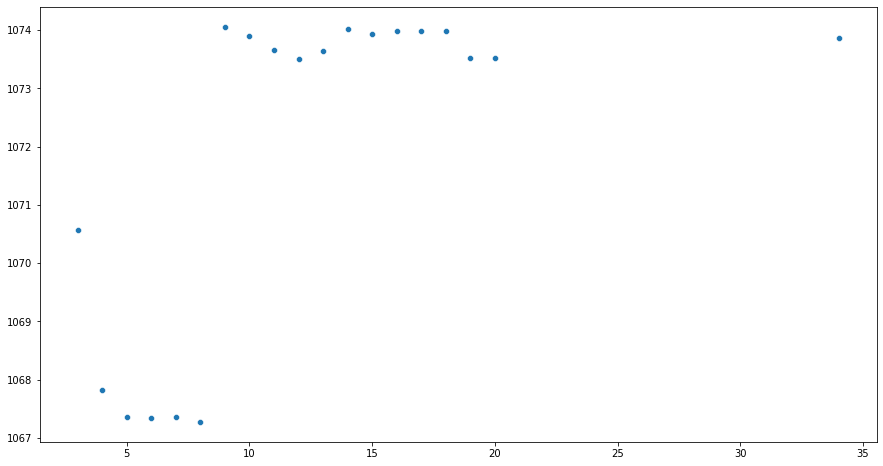

In [ ]:
thresholds = model.feature_importances_
selected_thresholds = []
best_scores_dict = {}
threshold_count = []
best_scores = []
for threshold in thresholds:
  if threshold not in selected_thresholds:
    print('threshold %f' % threshold)
    selected_thresholds.append(threshold)
    select_X_train = SelectFromModel(model.feature_importances_, X_train.columns.to_numpy(), threshold)
    print(select_X_train)
    print(len(select_X_train))
    xgb_model = xgb.XGBRegressor(random_state=353,learning_rate=0.05,reg_lambda=9)
    xgb_model.fit(X_train[select_X_train],y_train, eval_set=[(X_val[select_X_train], y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=20)
    if(xgb_model.best_score<=1100):
      threshold_count.append(len(select_X_train))
      best_scores.append(xgb_model.best_score)
    del xgb_model
    del select_X_train
    print('==============================================================')

plt.figure(figsize=(15,8))
sns.scatterplot(x=threshold_count, y=best_scores)

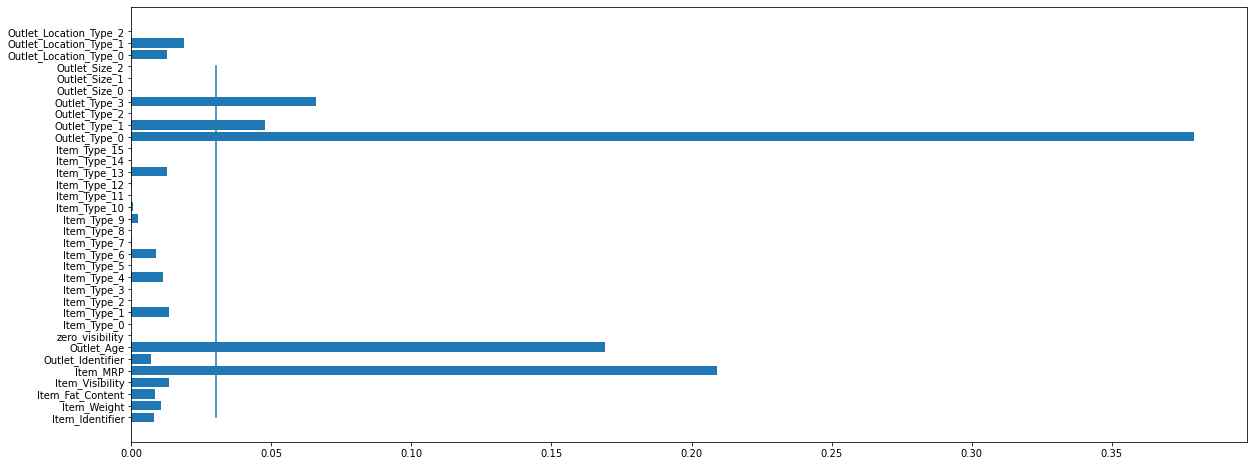

In [ ]:
plt.figure(figsize=(20,8))
plt.barh(X_train.columns, model.feature_importances_)
plt.plot([0.030303031,0.030303031],[0,30])

In [ ]:
model = xgb.XGBRegressor()
eval_set = [(X_train,y_train), (X_val,y_val)]
model.fit(X_train,y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10, verbose=False)

[08:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
results = model.evals_result()

In [ ]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0,epochs)

Text(0.5, 1.0, 'XGBoost baseline RMSE')

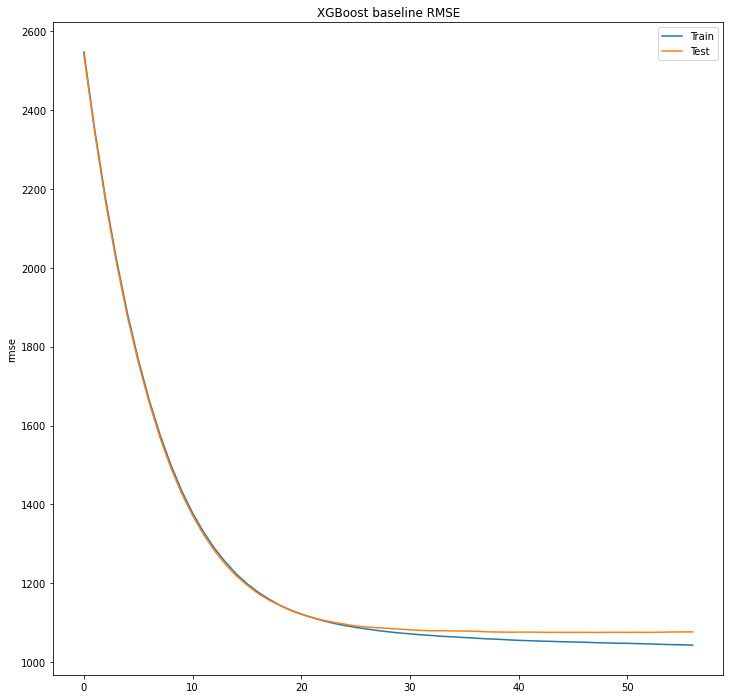

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("rmse")
plt.title("XGBoost baseline RMSE")

In [ ]:
model = xgb.XGBRegressor(random_state=35,learning_rate=0.05,reg_lambda=9)
eval_set = [(X_train,y_train), (X_val,y_val)]
model.fit(X_train,y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10, verbose=False)

[08:09:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=35,
             reg_alpha=0, reg_lambda=9, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
results = model.evals_result()

In [ ]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0,epochs)

Text(0.5, 1.0, 'XGBoost baseline RMSE')

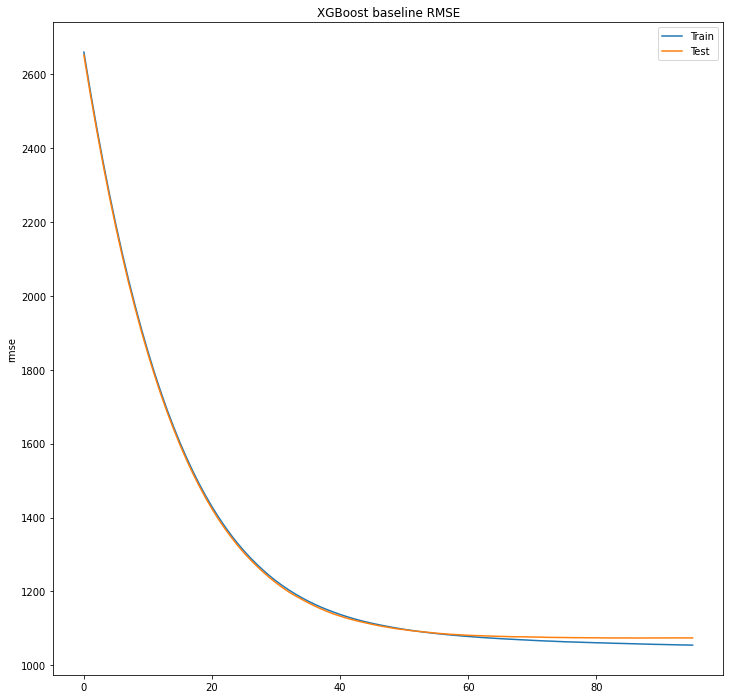

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("rmse")
plt.title("XGBoost baseline RMSE")

In [ ]:
X_train_selected_features = X_train.loc[:,['Item_MRP', 'Outlet_Age', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_3', 'Outlet_Location_Type_1','Outlet_Size_0']]
X_val_selected_features = X_val.loc[:,['Item_MRP', 'Outlet_Age', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_3', 'Outlet_Location_Type_1','Outlet_Size_0']]

In [ ]:
model = xgb.XGBRegressor(random_state=35,learning_rate=0.05,reg_lambda=9)
eval_set = [(X_train_selected_features,y_train), (X_val_selected_features,y_val)]
model.fit(X_train_selected_features,y_train, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10, verbose=False)

[08:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=35,
             reg_alpha=0, reg_lambda=9, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
results = model.evals_result()

In [ ]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0,epochs)

Text(0.5, 1.0, 'XGBoost baseline RMSE')

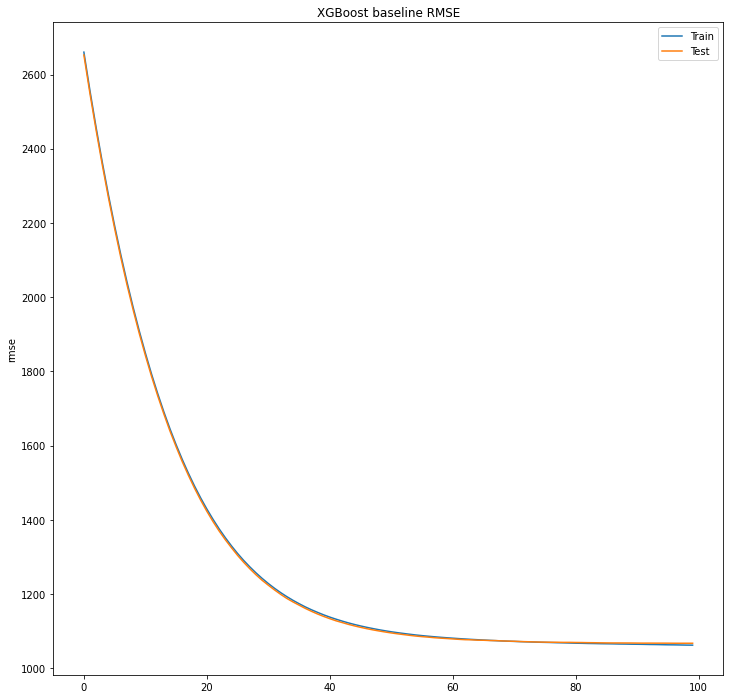

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("rmse")
plt.title("XGBoost baseline RMSE")

In [ ]:
test_xgb_selected_features = test_xgb.loc[:,['Item_MRP', 'Outlet_Age', 'Outlet_Type_0', 'Outlet_Type_1', 'Outlet_Type_3', 'Outlet_Location_Type_1','Outlet_Size_0']]

In [ ]:
xgb_predictions = model.predict(test_xgb_selected_features)

#####Save as CSV

In [ ]:
submission_df = pd.DataFrame({'Item_Identifier': test_original.Item_Identifier, 'Outlet_Identifier': test_original.Outlet_Identifier})

In [ ]:
submission_df.head()

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027


In [ ]:
submission_df['Item_Outlet_Sales'] = xgb_predictions

In [ ]:
submission_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1685.610840
1,FDW14,OUT017,1389.264038
2,NCN55,OUT010,644.549316
3,FDQ58,OUT017,2570.071777
4,FDY38,OUT027,5733.498047


In [ ]:
submission_df.to_csv('submission.csv', index=False)